In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Import data

In [2]:
# Upload the data file
df = pd.read_csv("df_cleaned.csv")

# Remove homes with unknown service line material
df = df[df["System-Owned Portion Service Line Material Classification "] != "MU"]

# Create binary classification for lead or non-lead pipes
df["is_lead"] = (df["System-Owned Portion Service Line Material Classification "]=="PB").astype(int)


/var/folders/68/w_2pz71n3c54dvg5_3838cxw0000gn/T/ipykernel_23542/2866953545.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_cleaned.csv")


### Some preliminary visualization

In [3]:
df.columns 

Index(['Unnamed: 0', 'PARCEL ID', 'YEARBLT', 'APPRTOT', 'PRICE', 'GRADE',
       'NBRHD', 'Street Number', 'Street Name', 'City', 'Zip Code', 'County',
       'Latitude', 'Longitude',
       'System-Owned Portion Service Line Material Classification ',
       'If Non-Lead in Column R.. Was Material Ever Previously Lead?',
       'Customer-Owned Portion Service Line Material Classification',
       'is_lead'],
      dtype='object')

In [4]:
from sklearn.preprocessing import LabelEncoder

df_corr = df[['Latitude', 'Longitude', 'YEARBLT', 'APPRTOT', 'GRADE', 'Zip Code', 'County', 'is_lead']].copy()

# Encode GRADE (assumed small number of categories)
df_corr['GRADE'] = LabelEncoder().fit_transform(df_corr['GRADE'])

# Encode large categoricals like Zip Code and County numerically just to get rough correlation
df_corr['Zip Code'] = LabelEncoder().fit_transform(df_corr['Zip Code'].astype(str))
df_corr['County'] = LabelEncoder().fit_transform(df_corr['County'].astype(str))

feature_corr = df_corr.corr()['is_lead'].drop('is_lead')
print(" Feature Correlation with Lead Presence:\n")
print(feature_corr.reindex(feature_corr.abs().sort_values(ascending=False).head(10).index))

 Feature Correlation with Lead Presence:

YEARBLT     -0.452103
Latitude    -0.072932
GRADE        0.054003
APPRTOT     -0.050119
County       0.005956
Zip Code    -0.000306
Longitude   -0.000046
Name: is_lead, dtype: float64


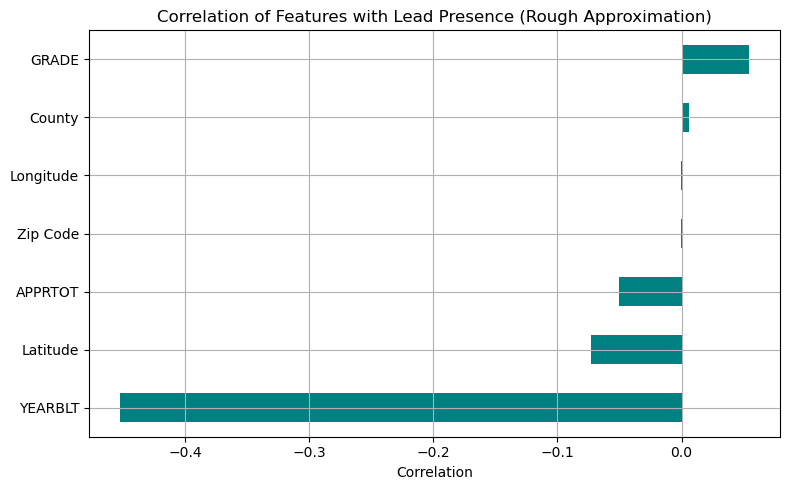

In [5]:

plt.figure(figsize=(8, 5))
feature_corr.sort_values().plot(kind='barh', color='teal')
plt.title('Correlation of Features with Lead Presence (Rough Approximation)')
plt.xlabel('Correlation')
plt.tight_layout()
plt.grid(True)
plt.show()

<Axes: xlabel='is_lead', ylabel='YEARBLT'>

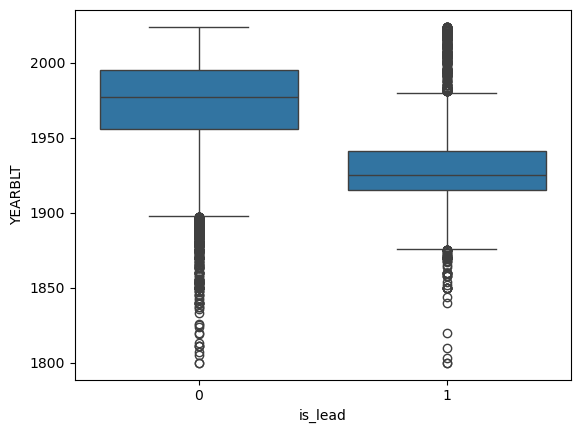

In [6]:
# Visualization: Year built corerlation with is_lead
sns.boxplot(x='is_lead', y='YEARBLT', data=df)


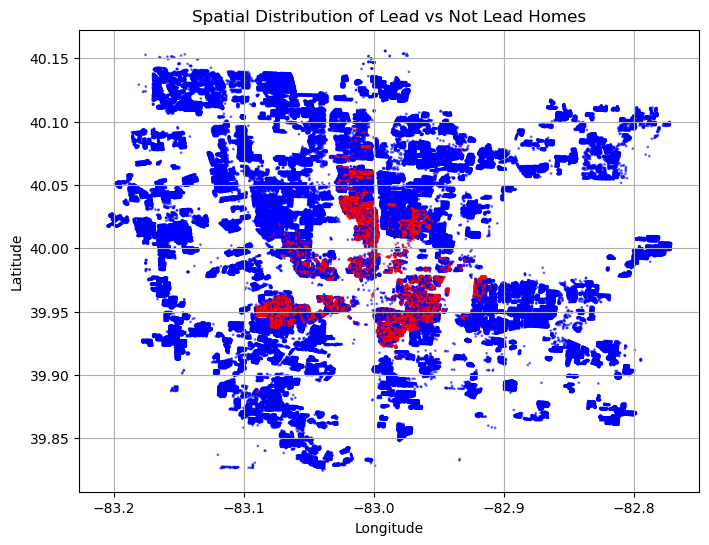

In [7]:
# Visualization: Distribution of service line material
plt.figure(figsize=(8, 6))
colors = df['is_lead'].map({1: 'red', 0: 'blue'})
plt.scatter(df['Longitude'], df['Latitude'], c=colors, alpha=0.5, marker='o', s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Lead vs Not Lead Homes')
plt.grid(True)
plt.show()


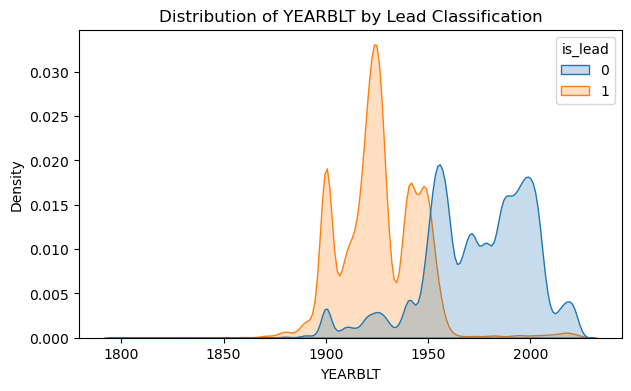

In [8]:
for col in ['YEARBLT']:
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df, x=col, hue='is_lead', fill=True, common_norm=False)
    plt.title(f'Distribution of {col} by Lead Classification')
    plt.show()

### KNN Models

In [9]:
# Features and target
X = df[['Latitude', 'Longitude', 'YEARBLT']]  
y = df['is_lead']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [10]:
# Preprocessing pipeline: scale numerical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Latitude', 'Longitude', 'YEARBLT'])
])

# Full pipeline
# Preprocessing to scale numerical features
# KNN classifier
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto'))
])



In [11]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Latitude', 'Longitude',
                                                   'YEARBLT'])])),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=8, weights='distance'))])

Threshold: 0.1
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     36829
           1       0.52      0.94      0.67      3447

    accuracy                           0.92     40276
   macro avg       0.76      0.93      0.81     40276
weighted avg       0.95      0.92      0.93     40276

F2 Score: 0.81152
Threshold: 0.15000000000000002
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     36829
           1       0.55      0.92      0.69      3447

    accuracy                           0.93     40276
   macro avg       0.77      0.92      0.82     40276
weighted avg       0.95      0.93      0.94     40276

F2 Score: 0.80958
Threshold: 0.20000000000000004
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     36829
           1       0.57      0.89      0.70      3447

    accuracy                           0.93     40276
   macro avg   

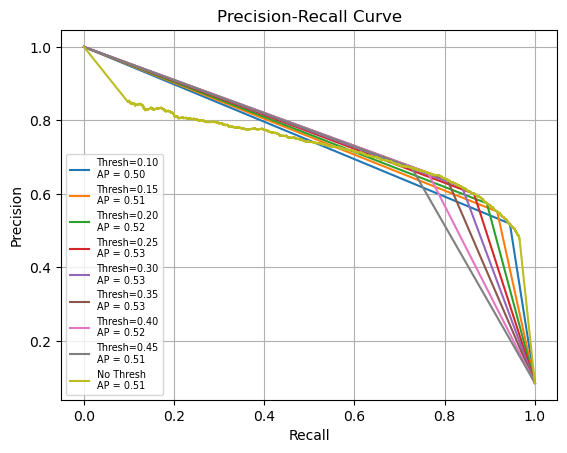

In [13]:
threshold=np.arange(0.1,0.5,.05)
y_probs = knn_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities of class 1
confusion_matrices={}
f2_scores = []

for t in threshold:
    print(f"Threshold: {t}")
    y_pred_thresh = (y_probs > t).astype(int)  # Lower threshold = more positives
    confusion_matrices[t]=(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_thresh)
    avg_precision = average_precision_score(y_test, y_pred_thresh)
    f2_score = fbeta_score(y_test, y_pred_thresh, beta=2)
    f2_scores.append(f2_score)
    
    print(f'F2 Score: {f2_score:.5f}')


    plt.plot(recall, precision, label=f'Thresh={t:.2f}\nAP = {avg_precision:.2f}')

precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, label=f'No Thresh\nAP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(fontsize='x-small')
plt.show()

   


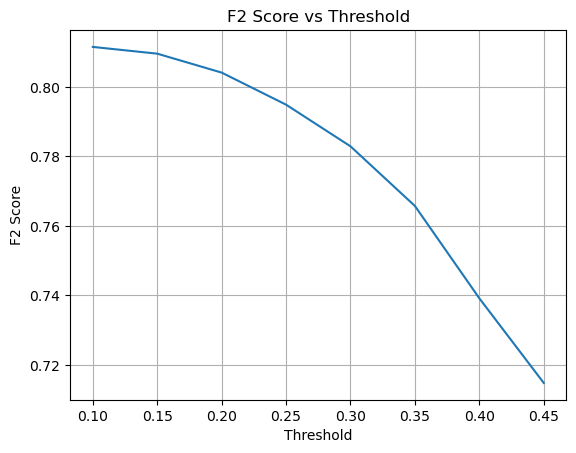

In [14]:
plt.plot(threshold, f2_scores)
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.title('F2 Score vs Threshold')
plt.grid(True)
plt.xticks(threshold)
plt.show()

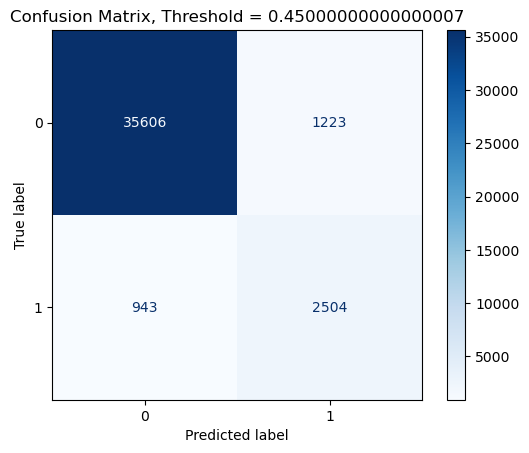

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, cmap='Blues')
plt.title(f"Confusion Matrix, Threshold = {t}")
plt.show()

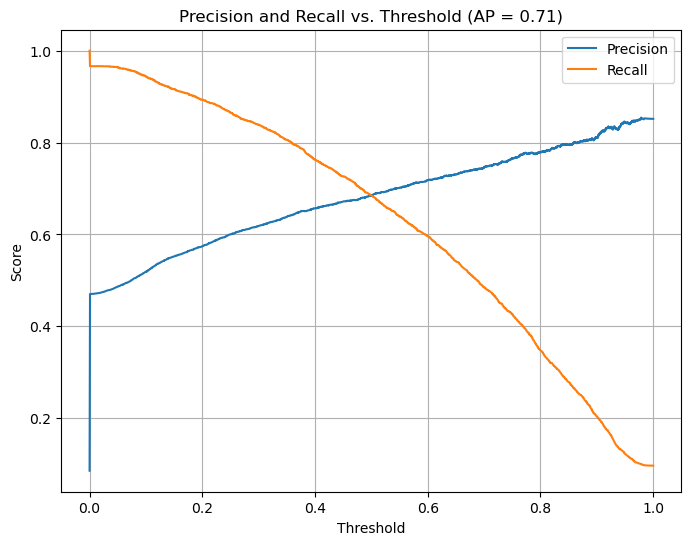

In [ ]:
# Get predicted probabilities
y_probs = knn_pipeline.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_prec = average_precision_score(y_test, y_probs)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Precision and Recall vs. Threshold (AP = {avg_prec:.2f})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Say you want at least 85% recall
target_recall = 0.85
idx = np.where(recall >= target_recall)[0][-1]  # last threshold that still gives >= 0.85 recall
best_thresh = thresholds[idx]
print(f"Threshold for ≥{target_recall*100:.0f}% recall: {best_thresh:.2f}")

Threshold for ≥85% recall: 0.27


In [ ]:
# Combine into one DataFrame
y_pred_thresh = (y_probs > .27).astype(int)
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred_thresh
results['Probability'] = y_probs

In [ ]:
def classify_result(row):
    if row['Actual'] == 1 and row['Predicted'] == 1:
        return 'True Positive'
    elif row['Actual'] == 0 and row['Predicted'] == 1:
        return 'False Positive'
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        return 'False Negative'
    else:
        return 'True Negative'

results['Outcome'] = results.apply(classify_result, axis=1)

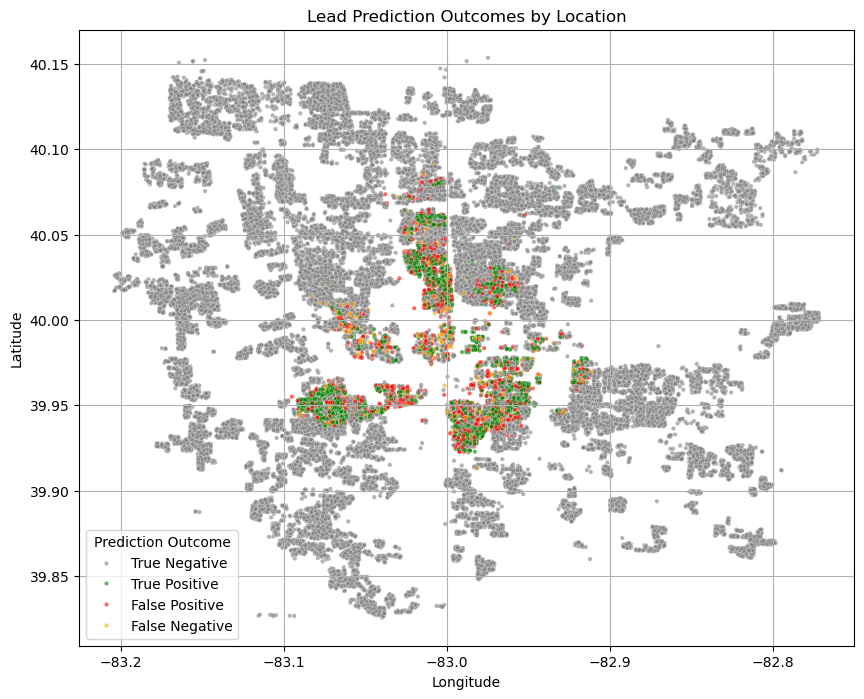

In [ ]:
# Custom palette
palette = {
    'True Positive': 'green',
    'False Positive': 'red',
    'False Negative': 'orange',
    'True Negative': 'gray'
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results,
    x='Longitude',
    y='Latitude',
    hue='Outcome',
    palette=palette,
    alpha=0.6,
    s=10
)
plt.title('Lead Prediction Outcomes by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Prediction Outcome')
plt.show()


In [ ]:
predicted_positive = results[results['Predicted'] == 1]


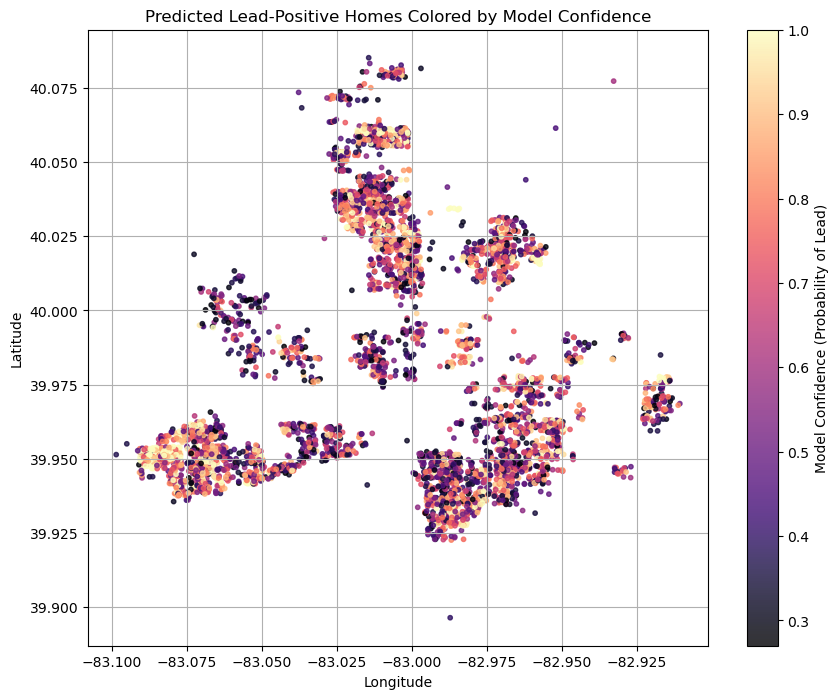

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    predicted_positive['Longitude'],
    predicted_positive['Latitude'],
    c=predicted_positive['Probability'],
    cmap='magma',
    alpha=0.8,
    s=10,
)

plt.colorbar(scatter, label='Model Confidence (Probability of Lead)')
plt.title('Predicted Lead-Positive Homes Colored by Model Confidence')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
total = len(y_test)

print("🔍 Summary Statistics")
print(f"Total samples: {total}")
print(f"True Positives:     {tp} ({tp / total:.2%})")
print(f"False Positives:    {fp} ({fp / total:.2%})")
print(f"False Negatives:    {fn} ({fn / total:.2%})")
print(f"True Negatives:     {tn} ({tn / total:.2%})")

accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy:  {accuracy:.2%}")
print(f" Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1 Score:  {f1:.2%}")

🔍 Summary Statistics
Total samples: 40276
True Positives:     2936 (7.29%)
False Positives:    1891 (4.70%)
False Negatives:    511 (1.27%)
True Negatives:     34938 (86.75%)

Accuracy:  94.04%
 Precision: 60.82%
Recall:    85.18%
F1 Score:  70.97%
